In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torch

In [3]:
def show_random_images(image_path):
    img = Image.open(image_path)
    plt.imshow(img)

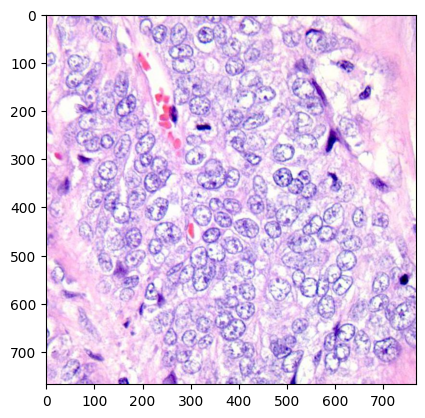

In [4]:
show_random_images("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg")

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class TissueCancerDataset(Dataset):
    def __init__(self, cancer_dir, no_cancer_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load cancer images (label 1)
        cancer_images = [(os.path.join(cancer_dir, img), 1) 
                        for img in os.listdir(cancer_dir)]
        
        # Load no-cancer images (label 0)
        no_cancer_images = [(os.path.join(no_cancer_dir, img), 0) 
                           for img in os.listdir(no_cancer_dir)]
        
        # Combine and shuffle
        all_images = cancer_images + no_cancer_images
        np.random.shuffle(all_images)
        
        # Split into paths and labels
        self.image_paths, self.labels = zip(*all_images)
        
        # Convert to tensors
        self.labels = torch.LongTensor(self.labels)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
def create_dataloaders(cancer_dir, no_cancer_dir, batch_size=32, train_split=0.85):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to standard size
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = TissueCancerDataset(
        cancer_dir=cancer_dir,
        no_cancer_dir=no_cancer_dir,
        transform=train_transform
    )
    
    # Calculate lengths for split
    train_size = int(train_split * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # Split dataset
    train_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Override transform for test dataset
    test_dataset.dataset.transform = test_transform
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, test_loader

In [7]:
# Function to visualize batch
def show_batch(dataloader, num_images=8):
    # Get a batch
    images, labels = next(iter(dataloader))
    
    # Create grid of images
    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, num_images//2, i+1)
        
        # Convert tensor to image
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f'Label: {"Cancer" if labels[i] == 1 else "No Cancer"}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

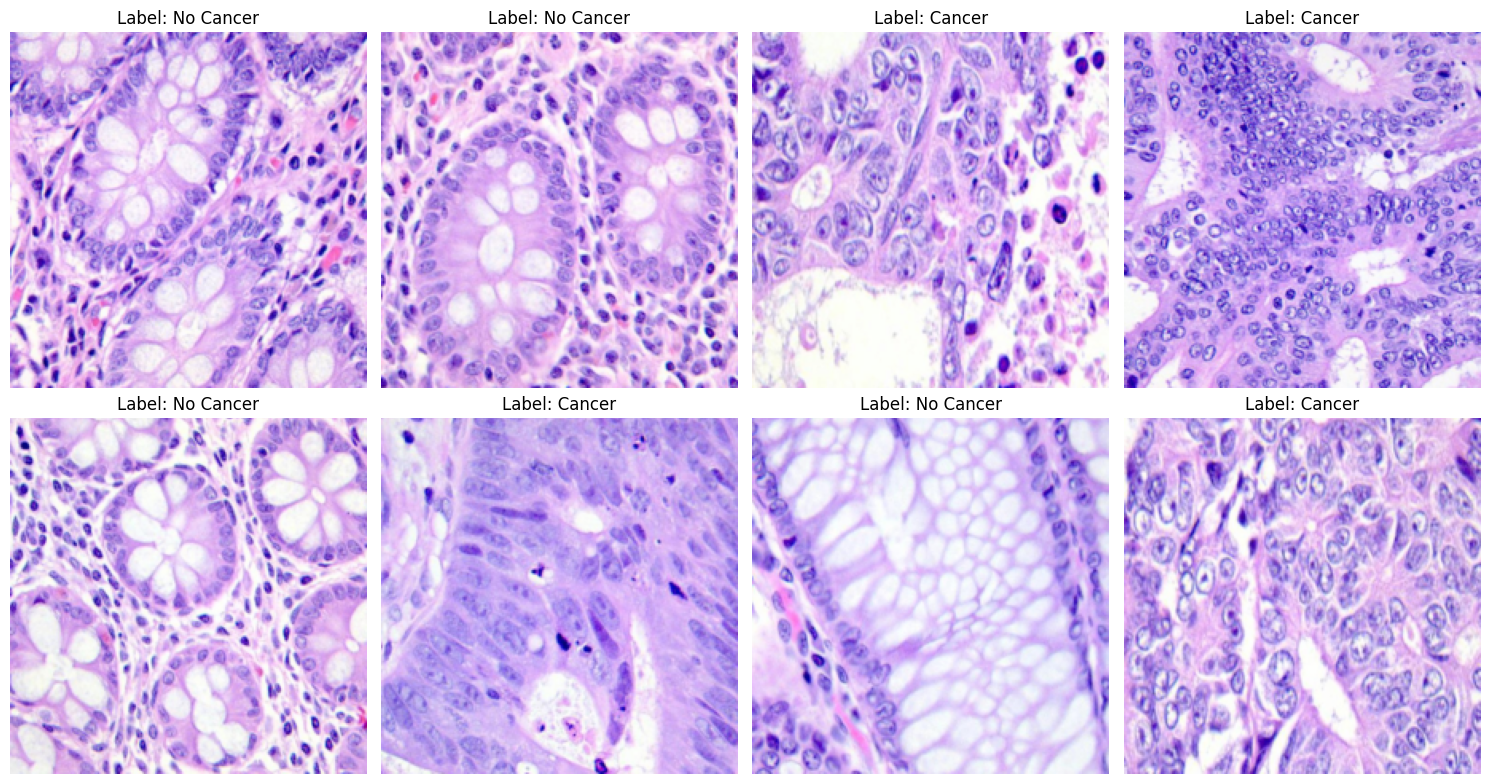

In [8]:
cancer_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca"
no_cancer_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n"

# Create dataloaders
train_loader, test_loader = create_dataloaders(
    cancer_dir=cancer_dir,
    no_cancer_dir=no_cancer_dir,
    batch_size=32,
    train_split=0.85
)

# Show a batch of training images
show_batch(train_loader)

In [9]:
!pip install git+https://github.com/D-X-Y/AutoDL-Projects

  Cloning https://github.com/D-X-Y/AutoDL-Projects to /tmp/pip-req-build-wh02ub4j
  Running command git clone --filter=blob:none --quiet https://github.com/D-X-Y/AutoDL-Projects /tmp/pip-req-build-wh02ub4j
  Resolved https://github.com/D-X-Y/AutoDL-Projects to commit f46486e21b71ae6459a700be720d7648b5429569
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for xautodl: filename=xautodl-1.0.0-py3-none-any.whl size=225892 sha256=9f4a1022edf23b3e7a21fc6553abadadbc91cdc72a7cb1dfd2b83caff4355b50
  Stored in directory: /tmp/pip-ephem-wheel-cache-iiqmy2u4/wheels/b7/7c/20/27ef34d8a74c03c1aafea98528b84f6bc84dc2e5cf98fc2ed0
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-n

In [10]:
model = torch.load('/kaggle/input/genericclassificationmodel/pytorch/default/1/network.pt')

/tmp/ipykernel_30/2494669721.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/input/genericclassificationmodel/pytorch/default/1/network.pt')


In [11]:
import torch.nn as nn
model.classifier = nn.Linear(in_features=40, out_features=2, bias=True)

In [19]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

EPOCH = 15
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()#nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.1, 
        patience=2, 
        verbose=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(EPOCH):
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader)):
        inputs, targets = data 
        inputs = inputs.to(device)
        targets = targets.type(torch.LongTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)[1]
        
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 49 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.type(torch.LongTensor).to(device)
            
            outputs = model(inputs)[1]
            loss = criterion(outputs, targets)
                
            predicted = F.softmax(outputs).argmax(dim=-1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
                
            test_loss += loss.item()
        
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy}")
        
    # Update learning rate
    scheduler.step(avg_test_loss)

51it [00:08,  6.54it/s]

[1,    50] loss: 0.350


101it [00:16,  6.36it/s]

[1,   100] loss: 0.329


151it [00:24,  6.14it/s]

[1,   150] loss: 0.315


201it [00:33,  5.27it/s]

[1,   200] loss: 0.313


250it [00:43,  6.15it/s]

[1,   250] loss: 0.314


266it [00:46,  5.75it/s]
/tmp/ipykernel_30/1356016260.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted = F.softmax(outputs).argmax(dim=-1)


Test Accuracy: 90.2


51it [00:10,  5.45it/s]

[2,    50] loss: 0.290


100it [00:19,  5.64it/s]

[2,   100] loss: 0.298


151it [00:29,  6.58it/s]

[2,   150] loss: 0.262


201it [00:37,  6.54it/s]

[2,   200] loss: 0.264


251it [00:45,  6.53it/s]

[2,   250] loss: 0.264


266it [00:47,  5.61it/s]


Test Accuracy: 92.06666666666666


51it [00:08,  6.20it/s]

[3,    50] loss: 0.259


101it [00:16,  6.55it/s]

[3,   100] loss: 0.239


151it [00:24,  6.32it/s]

[3,   150] loss: 0.252


201it [00:32,  6.48it/s]

[3,   200] loss: 0.217


251it [00:40,  5.44it/s]

[3,   250] loss: 0.242


266it [00:42,  6.20it/s]


Test Accuracy: 93.06666666666666


51it [00:08,  6.59it/s]

[4,    50] loss: 0.228


101it [00:16,  6.10it/s]

[4,   100] loss: 0.239


151it [00:24,  6.53it/s]

[4,   150] loss: 0.207


201it [00:32,  6.57it/s]

[4,   200] loss: 0.211


251it [00:40,  6.57it/s]

[4,   250] loss: 0.205


266it [00:43,  6.15it/s]


Test Accuracy: 93.73333333333333


51it [00:08,  5.36it/s]

[5,    50] loss: 0.206


100it [00:16,  6.57it/s]

[5,   100] loss: 0.204


151it [00:24,  5.98it/s]

[5,   150] loss: 0.212


201it [00:33,  6.58it/s]

[5,   200] loss: 0.183


251it [00:41,  5.55it/s]

[5,   250] loss: 0.184


266it [00:43,  6.05it/s]


Test Accuracy: 94.06666666666666


51it [00:08,  6.66it/s]

[6,    50] loss: 0.178


101it [00:16,  6.05it/s]

[6,   100] loss: 0.192


151it [00:24,  6.53it/s]

[6,   150] loss: 0.168


201it [00:32,  6.48it/s]

[6,   200] loss: 0.168


251it [00:39,  6.29it/s]

[6,   250] loss: 0.190


266it [00:42,  6.30it/s]


Test Accuracy: 94.06666666666666


51it [00:08,  6.36it/s]

[7,    50] loss: 0.180


101it [00:16,  6.73it/s]

[7,   100] loss: 0.169


151it [00:23,  6.65it/s]

[7,   150] loss: 0.160


201it [00:31,  6.59it/s]

[7,   200] loss: 0.159


250it [00:39,  4.93it/s]

[7,   250] loss: 0.169


266it [00:41,  6.38it/s]


Test Accuracy: 93.73333333333333


51it [00:08,  6.56it/s]

[8,    50] loss: 0.157


101it [00:15,  6.72it/s]

[8,   100] loss: 0.153


110it [00:17,  6.25it/s]


KeyboardInterrupt: 

In [23]:
torch.save(model, '/kaggle/working/model.pth')